In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math

In [20]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")

# data scaling

In [25]:
# precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
# precip_scaled = precip_scaler.fit_transform(np.array(data_no_missing.UDel_precip_popweight).reshape(-1,1)).flatten()
# gdp_scaled = gdp_scaler.fit_transform(np.array(data_no_missing.growthWDI).reshape(-1,1)).flatten()
# temp_scaled = temp_scaler.fit_transform(np.array(data_no_missing.UDel_temp_popweight).reshape(-1,1)).flatten()

precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# year and country fixed effect coefficient matrices

In [30]:
# data_len = len(data_no_missing.year)
# year_mult_mat = [np.zeros(data_len) for year in set(data_no_missing.year)]
# country_mult_mat = [np.zeros(data_len) for country in set(data_no_missing.iso)]
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
#for row_index, row in enumerate(data_no_missing.itertuples()):
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - 1960
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1

In [31]:
# gradual year-by-year effects
grad_effects_data = np.transpose(np.array(data_no_missing.loc[:, data_no_missing.columns.str.startswith(('_y'))]))

In [33]:
with pm.Model() as model:
    
    temp_prior = pm.Normal("temp_prior", 0, 1)
    temp_std = pm.HalfNormal("temp_std", 10)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=temp_scaled)

    precip_prior = pm.Normal("precip_prior", 0, 1)
    precip_std = pm.HalfNormal("precip_std", 10)
    precip_posterior = pm.Normal("precip_posterior", precip_prior, precip_std, observed=precip_scaled)

    gdp_intercept = pm.Normal('gdp_intercept',0,10)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,10)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,10)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,10)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,10)

    # year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 5, shape=(len(set(data_no_missing.year)))),axis=1)
    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 5, shape=(len(set(data.year)))),axis=1)
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_coefs*year_mult_mat,axis=0))

    # country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 5, shape=(len(set(data_no_missing.iso)))),axis=1)
    country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 5, shape=(len(set(data.iso)))),axis=1)
    country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum(country_coefs*country_mult_mat,axis=0))

    # gradual_effect_coefs = pt.expand_dims(pm.Normal("grad_effect_coefs", 0, 5, shape=(len(grad_effects_data))),axis=1)
    # gradual_effect_coefs = pm.Normal("grad_effect_coefs", 0, 5)
    # gradual_effects = pm.Deterministic("grad_effects",pt.sum(gradual_effect_coefs*grad_effects_data,axis=0))
    
    gdp_prior = pm.Deterministic(
        "gdp_prior",
        gdp_intercept +
        (temp_posterior * temp_gdp_coef) +
        (temp_sq_gdp_coef * pt.sqr(temp_posterior)) +
        (precip_posterior * precip_gdp_coef) +
        (precip_sq_gdp_coef * pt.sqr(precip_posterior)) +
        year_fixed_effects +
        country_fixed_effects #+
        # gradual_effects
    )
    
    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)

    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4158 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x288BBA6C0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28E8C19A0>) has multiple clients. This is likely an inconsistent random graph.
  war

In [34]:
with open ('../models/burke-reproduction-fixed-effects-missing-rows-imputed.pkl', 'wb') as buff:
    pkl.dump({
        "prior":prior,
        "trace":trace,
        "posterior":posterior,
        "precip_scaler":precip_scaler,
        "temp_scaler":temp_scaler,
        "gdp_scaler":gdp_scaler
    },buff)

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_6592/1857160435.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


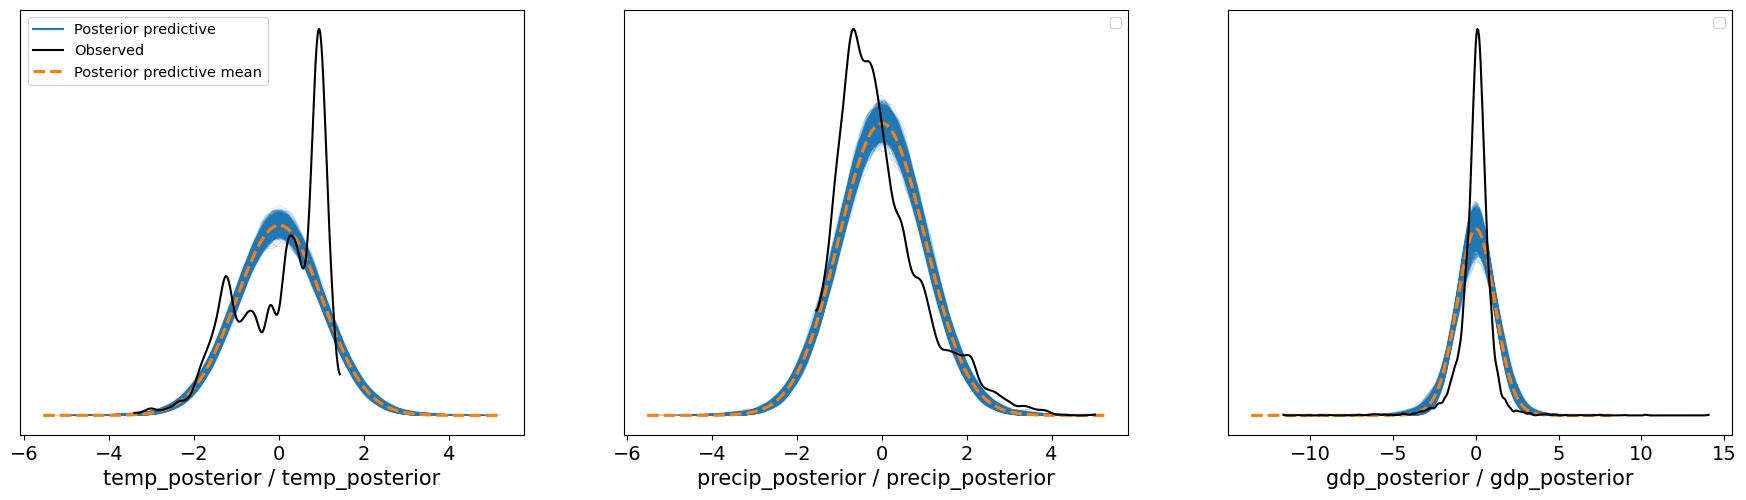

In [94]:
fig = az.plot_ppc(posterior,var_names=["temp_posterior","precip_posterior","gdp_posterior"]).ravel()[0].figure
fig.show()

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_6592/1883471754.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


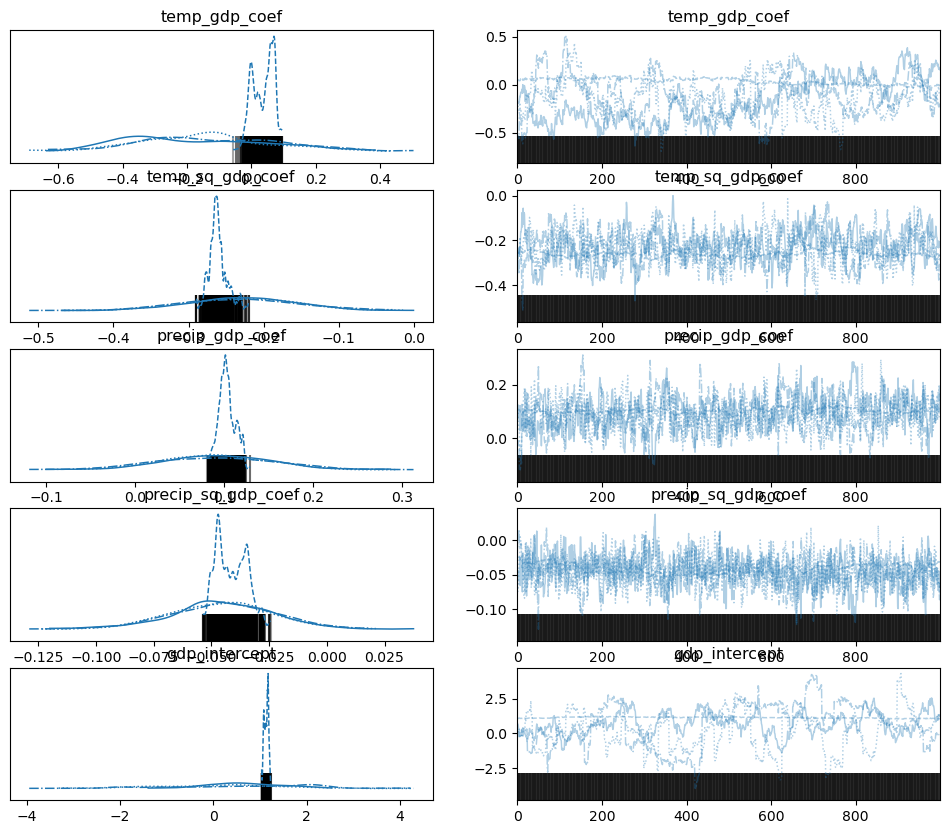

In [95]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"]).ravel()[0].figure
fig.show()

In [35]:
model = pd.read_pickle('../models/burke-reproduction-fixed-effects-missing-rows-imputed.pkl')

In [47]:
print(np.mean(trace.posterior.temp_gdp_coef.data))
print(np.mean(trace.posterior.temp_sq_gdp_coef.data))
print(np.mean(trace.posterior.precip_gdp_coef.data))
print(np.mean(trace.posterior.precip_sq_gdp_coef.data))
print(np.mean(trace.posterior.gdp_intercept.data))

-0.27238199123374524
-0.2245179922221322
0.08424386791856034
-0.04184700372372646
-0.16750102194166175


In [4]:
from sklearn.linear_model import LinearRegression
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
X = np.column_stack((
    data_no_missing.UDel_temp_popweight,
    np.square(data_no_missing.UDel_temp_popweight),
    data_no_missing.UDel_precip_popweight,
    np.square(data_no_missing.UDel_precip_popweight)
))
Y = np.array(data_no_missing.growthWDI).reshape(-1,1)
linreg = LinearRegression().fit(X,Y)
print(linreg.coef_)
print(linreg.intercept_)

[[ 8.38589795e-04 -4.50499041e-05  3.81664518e-06 -3.22334981e-10]]
[0.01702781]


In [36]:
#5
precip_data = precip_scaler.inverse_transform(np.array(model["posterior"].posterior_predictive.precip_posterior.data.flatten()).reshape(-1,1))
gdp_data = gdp_scaler.inverse_transform(np.array(model["posterior"].posterior_predictive.gdp_posterior.data.flatten()).reshape(-1,1))
temp_data = temp_scaler.inverse_transform(np.array(model["posterior"].posterior_predictive.temp_posterior.data.flatten()).reshape(-1,1))
X = np.column_stack((
    temp_data,
    np.square(temp_data),
    precip_data,
    np.square(precip_data)
))
linreg = LinearRegression().fit(X,gdp_data)
print(linreg.coef_)
print(linreg.intercept_)

[[ 5.62825698e-03 -1.69464812e-04  2.27297587e-05 -7.83555442e-09]]
[-0.02744623]


In [ ]:
# Targets:pt
# temp: .0084
# temp^2: -.00025
# precip: .000019
# precip^2: -5*e-9
# int: -.026

In [ ]:
# targets with grad effects:
# int: 1.457